In [529]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.linalg as linalg

# Exercise 0.1

In [3]:
# Given parameters
S0 = 100  # Spot price
K = 100   # Strike price
T = 1     # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Black-Scholes formula components
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Call option price
C = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Greeks
Delta = norm.cdf(d1)
Gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
Theta = -S0 * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)

print(f"Option Price: {C:.4f}")
print(f"Delta: {Delta:.4f}")
print(f"Gamma: {Gamma:.4f}")
print(f"Theta: {Theta:.4f}")

Option Price: 10.4506
Delta: 0.6368
Gamma: 0.0188
Theta: -6.4140


# Exercise 0.2

In [530]:
Value_of_forward = S0 - K * np.exp(-r * T)
Delta = 1
Gamma = 0
Theta = -r * K * np.exp(-r * T)

print("Forward Price: {:.4f}".format(Value_of_forward))
print("Delta: {:.4f}".format(Delta))
print("Gamma: {:.4f}".format(Gamma))
print("Theta: {:.4f}".format(Theta))

Forward Price: 4.8771
Delta: 1.0000
Gamma: 0.0000
Theta: -4.7561


# Exercise 1.1

In [85]:
def explicit_option_pricing(S0, K, T, r, sigma, M, N):
    dt = T / N
    dS = 2 * S0 / M

    V = np.zeros((M+1, N+1))
    # Boundary conditions
    V[:, -1] = np.maximum(np.linspace(0, S0*2, M+1) - K, 0)
    V[-1, :-1] = (S0*2 - K) * np.exp(-r * dt * np.arange(N, 0, -1))

    # Coefficients for the explicit method
    a = 0.5 * dt * (sigma**2 * np.arange(0, M+1)**2 - r * np.arange(0, M+1))
    b = 1 - dt * (sigma**2 * np.arange(0, M+1)**2 + r)
    c = 0.5 * dt * (sigma**2 * np.arange(0, M+1)**2 + r * np.arange(0, M+1))
    # Iterating over the grid to solve for option prices
    for j in reversed(range(N)):
        for i in range(1, M):
            V[i, j] = a[i] * V[i-1, j+1] + b[i] * V[i, j+1] + c[i] * V[i+1, j+1]

    # Calculating the Greeks
    delta = (V[M//2 + 1, 0] - V[M//2 - 1, 0]) / (2 * dS)
    gamma = (V[M//2 + 1, 0] - 2 * V[M//2, 0] + V[M//2 - 1, 0]) / (dS**2)
    theta = (V[M//2, 1] - V[M//2, 0]) / dt

    # Extracting the option price at inception
    option_price = V[M//2, 0]

    return option_price, delta, gamma, theta

option_price, delta, gamma, theta = explicit_fdm_option_pricing(100, 100, 1.0, 0.05, 0.2, 150, 2000)
print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")


Option Price: 10.44568
Delta: 0.63652
Gamma: 0.01873
Theta: -6.40819


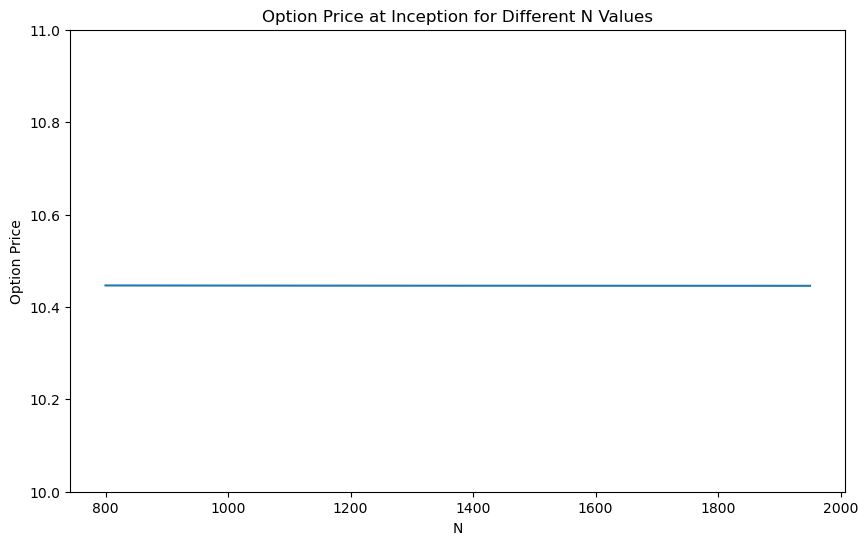

In [535]:
#plot the option price at inception for different N values
option_prices = []
M = 150
N = np.arange(800, 2000, 50)
for n in N:
    option_price, delta, gamma, theta = explicit_option_pricing(100, 100, 1.0, 0.05, 0.2, M, n)
    option_prices.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(N, option_prices)
plt.title('Option Price at Inception for Different N Values')
plt.xlabel('N')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

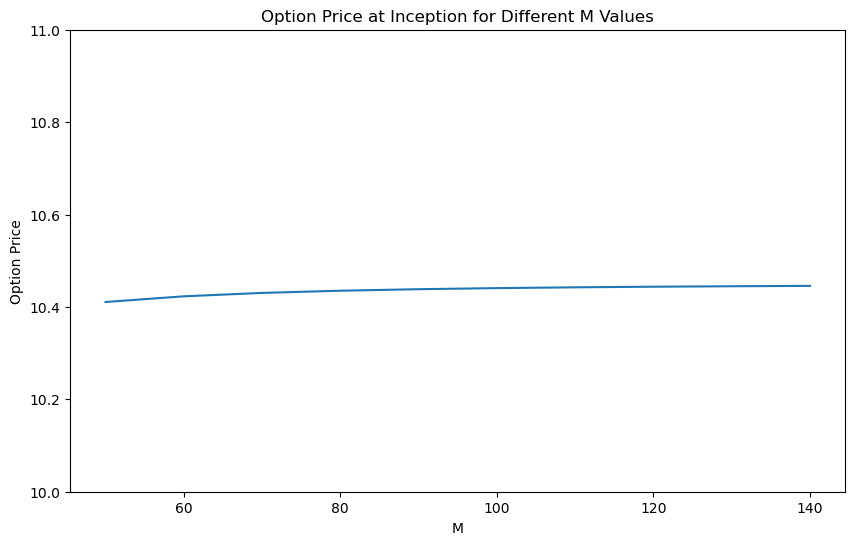

In [536]:
# plot the option price at inception for different M values
option_prices_with_m = []
M = np.arange(50, 150, 10)
N = 1000
for m in M:
    option_price, delta, gamma, theta = explicit_option_pricing(100, 100, 1.0, 0.05, 0.2, m, N)
    option_prices_with_m.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(M, option_prices_with_m)
plt.title('Option Price at Inception for Different M Values')
plt.xlabel('M')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

# Exercise 1.2

In [91]:
def implicit_option_pricing(S0, K, T, r, sigma, M, N):
    dt = T / N
    dS = 2 * S0 / M
    Smax = 2 * S0

    S = np.linspace(0, Smax, M + 1)
    t = np.linspace(0, T, N + 1)

    V = np.maximum(S - K, 0)  
    V_prev = np.zeros(M + 1)  

    a = -0.5 * dt * (sigma ** 2 * np.arange(M + 1) ** 2 - r * np.arange(M + 1))
    b = 1 + dt * (sigma ** 2 * np.arange(M + 1) ** 2 + r)
    c = -0.5 * dt * (sigma ** 2 * np.arange(M + 1) ** 2 + r * np.arange(M + 1))

    for j in range(N - 1, -1, -1):
        A = np.diag(b) + np.diag(a[1:], -1) + np.diag(c[:-1], 1)

        V[0] = 0
        V[-1] = Smax - K * np.exp(-r * (T - t[j]))

        V_prev = V.copy() 
        V = np.linalg.solve(A, V)

    i = M // 2
    option_price = V[i]
    delta = (V[i + 1] - V[i - 1]) / (2 * dS)
    gamma = (V[i + 1] - 2 * V[i] + V[i - 1]) / (dS ** 2)
    theta = -(V[i] - V_prev[i]) / dt  
    return option_price, delta, gamma, theta

option_price, delta, gamma, theta = implicit_option_pricing(100, 100, 1, 0.05, 0.2, 100, 3000)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.43476
Delta: 0.63558
Gamma: 0.01864
Theta: -6.38438


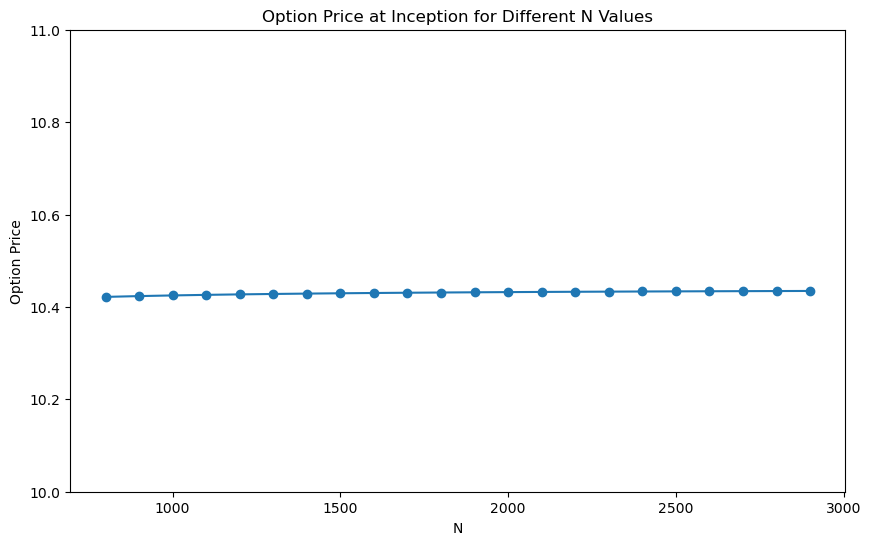

In [94]:
# plot the option price at inception for different N values
option_prices = []
M = 100
N = np.arange(800, 3000, 100)
for n in N:
    option_price, delta, gamma, theta = implicit_option_pricing(100, 100, 1.0, 0.05, 0.2, M, n)
    option_prices.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(N, option_prices, marker='o')
plt.title('Option Price at Inception for Different N Values')
plt.xlabel('N')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

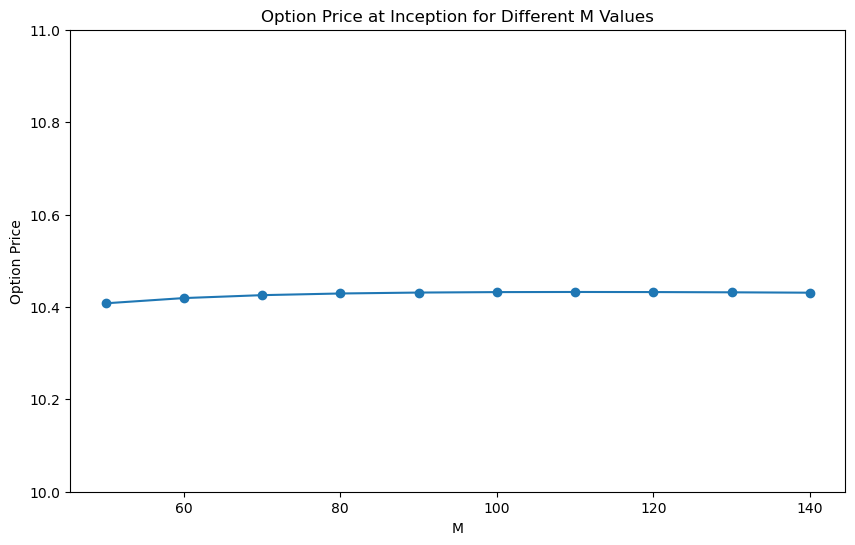

In [95]:
# plot the option price at inception for different M values
option_prices_with_m = []
M = np.arange(50, 150, 10)
N = 2000
for m in M:
    option_price, delta, gamma, theta = implicit_option_pricing(100, 100, 1.0, 0.05, 0.2, m, N)
    option_prices_with_m.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(M, option_prices_with_m, marker='o')
plt.title('Option Price at Inception for Different M Values')
plt.xlabel('M')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

# Exercise 1.3

In [101]:
def crank_nicolson_option_pricing(S0, K, T, r, sigma, M, N):
    dt = T / N
    dS = S0 * 2 / M
    Smax = 2 * S0

    S = np.linspace(0, Smax, M + 1)
    t = np.linspace(0, T, N + 1)

    V = np.maximum(S - K, 0)

    i = np.arange(0, M+1)
    alpha = -0.25 * dt * (sigma**2 * i**2 - r * i)
    beta = 1 + 0.5 * dt * (sigma**2 * i**2 + r)
    gamma = -0.25 * dt * (sigma**2 * i**2 + r * i)

    A = np.diag(beta) + np.diag(alpha[1:], -1) + np.diag(gamma[:-1], 1)
    B = np.diag(2 - beta) - np.diag(alpha[1:], -1) - np.diag(gamma[:-1], 1)

    for j in reversed(range(1, N)):
        V[0] = 0
        V[-1] = Smax - K * np.exp(-r * (T - t[j]))
        V_new = np.linalg.solve(A, B @ V)

        # Only calculate theta at the specific index after the first time step
        if j == 1:
            mid_index = M // 2  # Middle index for S0
            theta = -(V_new[mid_index] - V[mid_index]) / dt  # Scalar calculation of theta

        V = V_new  # Update the current V for the next iteration

    i = M // 2
    option_price = V[i]
    delta = (V[i + 1] - V[i - 1]) / (2 * dS)
    gamma = (V[i + 1] - 2 * V[i] + V[i - 1]) / (dS ** 2)

    return option_price, delta, gamma, theta

option_price, delta, gamma, theta = crank_nicolson_option_pricing(100, 100, 1, 0.05, 0.2, 100, 3000)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.43567
Delta: 0.63604
Gamma: 0.01872
Theta: -6.40196


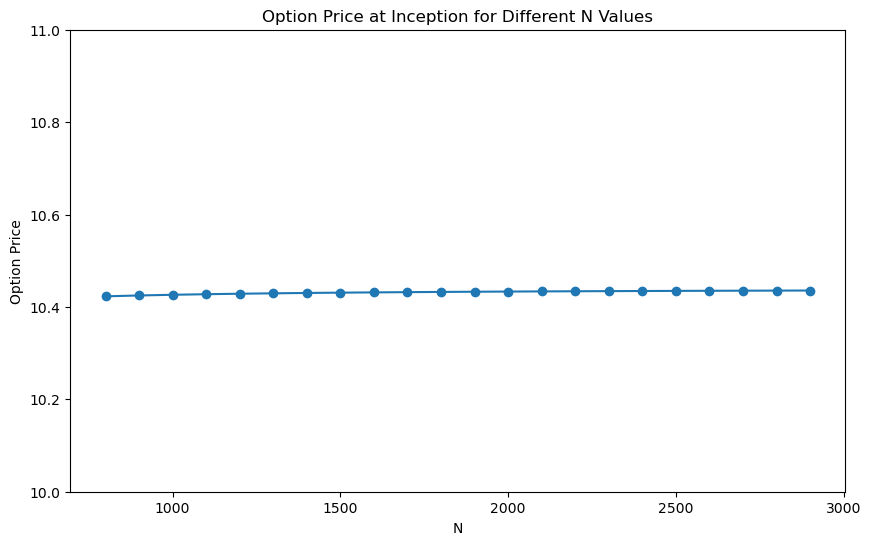

In [102]:
# plot the option price at inception for different N values
option_prices = []
M = 100
N = np.arange(800, 3000, 100)
for n in N:
    option_price, delta, gamma, theta = crank_nicolson_option_pricing(100, 100, 1.0, 0.05, 0.2, M, n)
    option_prices.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(N, option_prices, marker='o')
plt.title('Option Price at Inception for Different N Values')
plt.xlabel('N')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

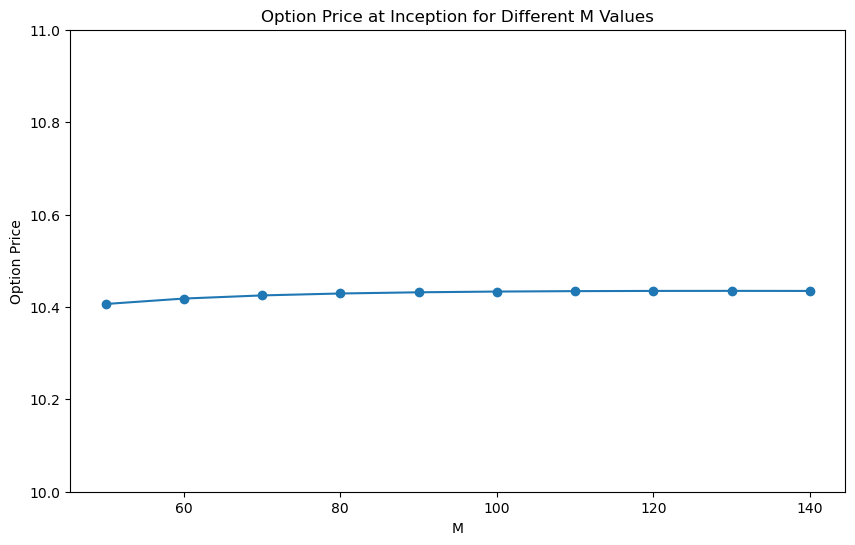

In [103]:
# plot the option price at inception for different M values
option_prices_with_m = []
M = np.arange(50, 150, 10)
N = 2000
for m in M:
    option_price, delta, gamma, theta = crank_nicolson_option_pricing(100, 100, 1.0, 0.05, 0.2, m, N)
    option_prices_with_m.append(option_price)

plt.figure(figsize=(10, 6))
plt.plot(M, option_prices_with_m, marker='o')
plt.title('Option Price at Inception for Different M Values')
plt.xlabel('M')
plt.ylabel('Option Price')
plt.ylim(10, 11)
plt.show()

# Excercise 2

In [104]:
# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1     # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Excercise 2.1 Monte-Carlo Using the closed-form formula

In [550]:
def simulate_stock_paths(S0, sigma, T, r, N):
    Z = np.random.standard_normal(N)
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    return ST

In [551]:
def monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N):
    ST = simulate_stock_paths(S0, sigma, T, r, N)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ST_plus = simulate_stock_paths(S0 + dS, sigma, T, r, N)
    ST_minus = simulate_stock_paths(S0 - dS, sigma, T, r, N)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(ST_plus - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(ST_minus - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 1/ 365
    # Theta calculation
    ST_future = simulate_stock_paths(S0, sigma, r, T + dT, N)
    ST_past = simulate_stock_paths(S0, sigma, r, T - dT, N)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(ST_future - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(ST_past - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)

    return C0, delta, gamma, theta

In [552]:
N = 100000
call_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.44557
Delta: 0.62576
Gamma: 0.01710
Theta: -7.16620


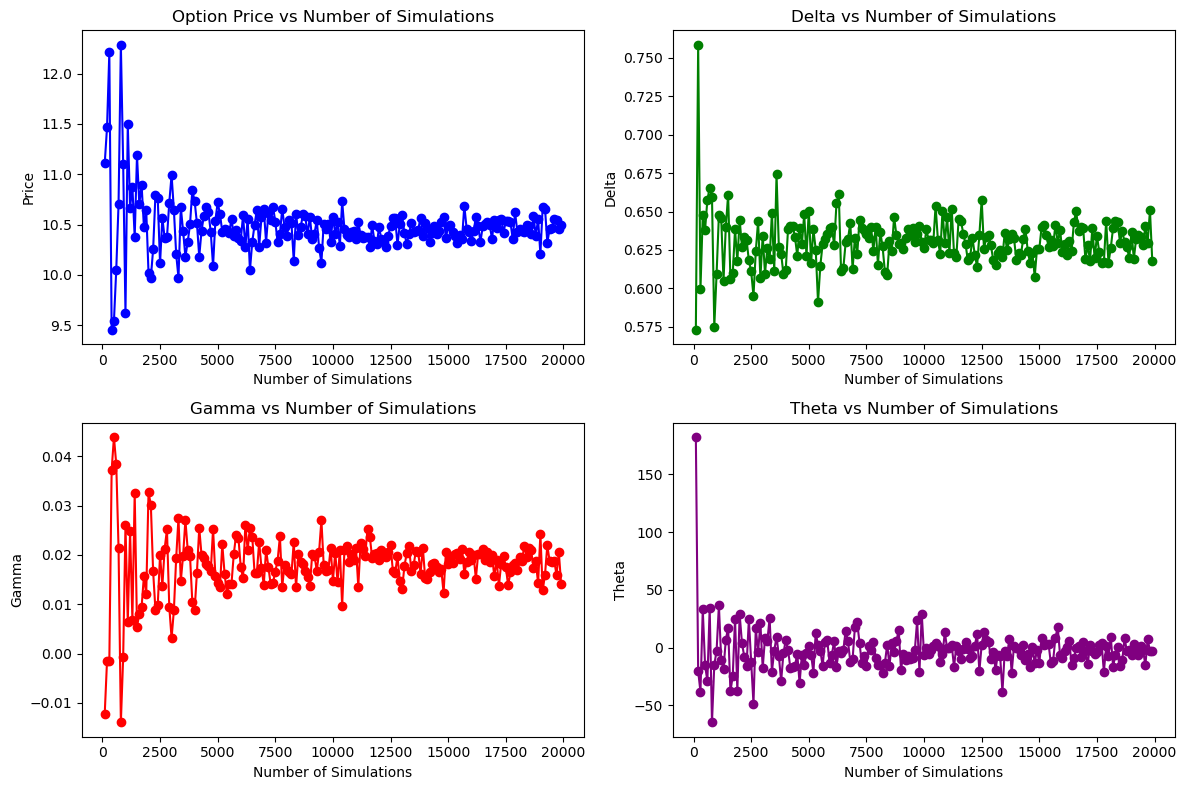

In [560]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(100, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)
    
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

# Excercise 2.2 Monte-Carlo using Euler schema

In [561]:
def euler_simulate_stock_paths(S0, sigma, T, r, N, dt):
    steps = int(T / dt)
    dt_sqrt = np.sqrt(dt)
    paths = np.zeros((N, steps + 1))
    paths[:, 0] = S0
    for i in range(1, steps + 1):
        Z = np.random.standard_normal(N)
        paths[:, i] = paths[:, i - 1] + r * paths[:, i - 1] * dt + sigma * paths[:, i - 1] * dt_sqrt * Z
    return paths[:, -1] 

In [562]:
def monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt):
    ST = euler_simulate_stock_paths(S0, sigma, T, r, N, dt)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ST_plus = euler_simulate_stock_paths(S0 + dS, sigma, T, r, N, dt)
    ST_minus = euler_simulate_stock_paths(S0 - dS, sigma, T, r, N, dt)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(ST_plus - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(ST_minus - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 1/ 365
    # Theta calculation
    ST_future = euler_simulate_stock_paths(S0, sigma, T + dT, r, N, dt)
    ST_past = euler_simulate_stock_paths(S0, sigma, T - dT, r, N, dt)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(ST_future - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(ST_past - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)

    return C0, delta, gamma, theta

In [589]:
N = 10000
dt = 1/ 365
call_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.49906
Delta: 0.64586
Gamma: 0.02108
Theta: -2.56136


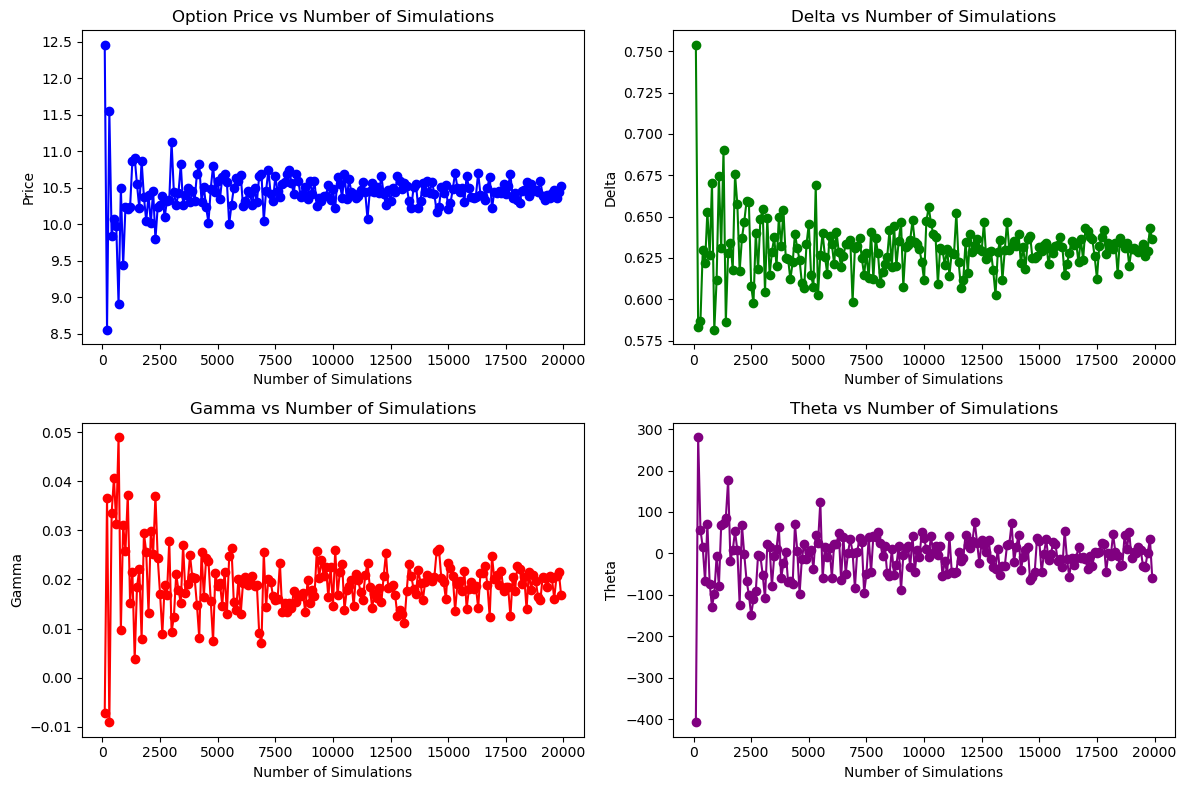

In [592]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(100, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n, 1/ 365)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

# Excercise 2.3 Monte-Carlo Using a Milstein schema

In [593]:
def Milstein_simulate_stock_paths(S0, sigma, T, r, N, dt):
    steps = int(T / dt)
    dt_sqrt = np.sqrt(dt)
    paths = np.zeros((N, steps + 1))
    paths[:, 0] = S0
    for i in range(1, steps + 1):
        Z = np.random.standard_normal(N)
        delta_W = np.sqrt(dt) * Z
        paths[:, i] = paths[:, i-1] * (1 + r * dt + sigma * delta_W + 0.5 * sigma**2 * (delta_W**2 - dt))
    return paths[:, -1] 

In [594]:
def monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt):
    ST = Milstein_simulate_stock_paths(S0, sigma, T, r, N, dt)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ST_plus = Milstein_simulate_stock_paths(S0 + dS, sigma, T, r, N, dt)
    ST_minus = Milstein_simulate_stock_paths(S0 - dS, sigma, T, r, N, dt)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(ST_plus - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(ST_minus - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 0.01
    # Theta calculation
    ST_future = Milstein_simulate_stock_paths(S0, sigma, T + dT, r, N, dt)
    ST_past = Milstein_simulate_stock_paths(S0, sigma, T - dT, r, N, dt)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(ST_future - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(ST_past - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)

    return C0, delta, gamma, theta

In [262]:
N = 10000
dt = 1/ 365
call_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.53317
Delta: 0.63166
Gamma: 0.01196
Theta: -6.49051


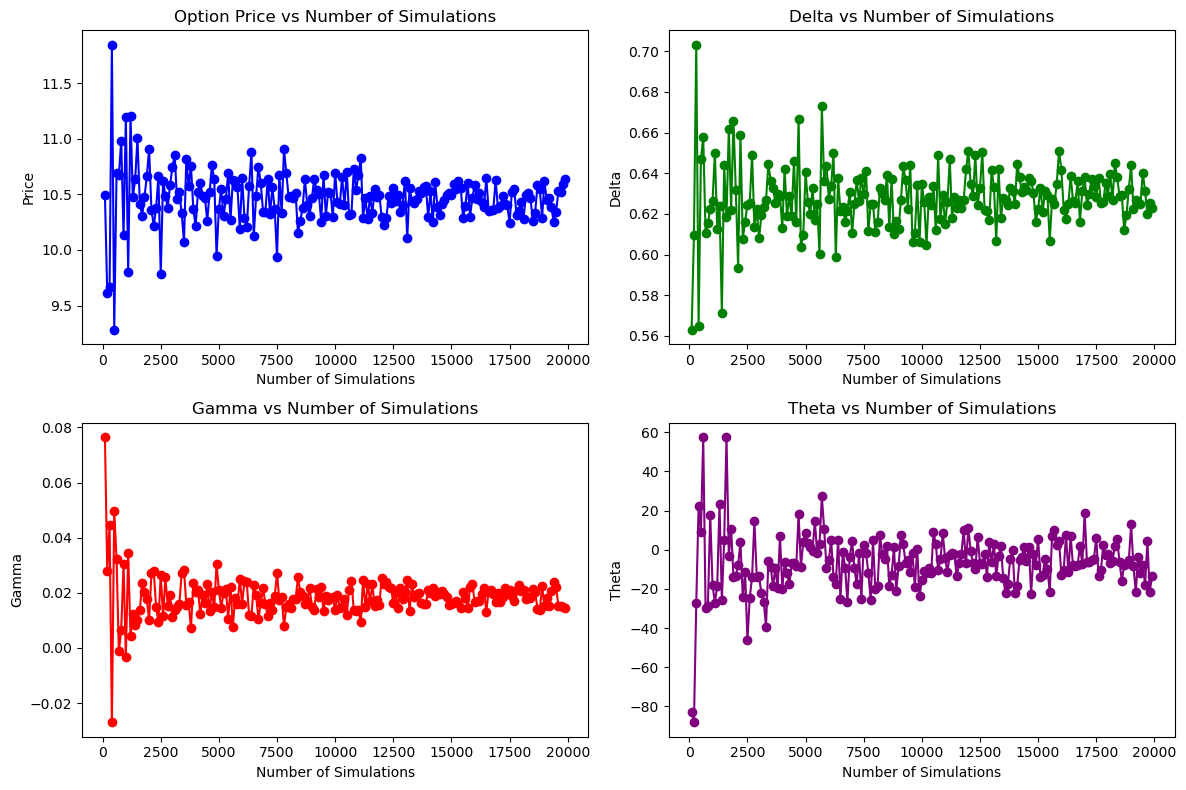

In [595]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(100, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n, 1/ 365)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)
    
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show() 

# Excercise 2.5.1 Monte-Carlo Using the closed-form formula with ln(St) condition

In [596]:
def simulate_stock_paths(S0, sigma, T, r, N):
    Z = np.random.standard_normal(N)
    ln_ST = np.log(S0) + (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z
    return ln_ST

In [597]:
def ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N):
    ln_ST = simulate_stock_paths(S0, sigma, T, r, N)
    ST = np.exp(ln_ST)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ln_ST_plus = simulate_stock_paths(S0 + dS, sigma, T, r, N)
    ln_ST_minus = simulate_stock_paths(S0 - dS, sigma, T, r, N)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_plus) - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_minus) - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 1/ 365
    # Theta calculation
    ln_ST_future = simulate_stock_paths(S0, sigma, r, T + dT, N)
    ln_ST_past = simulate_stock_paths(S0, sigma, r, T - dT, N)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(np.exp(ln_ST_future) - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(np.exp(ln_ST_past) - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)
    
    return C0, delta, gamma, theta

In [319]:
N = 10000
option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.31764
Delta: 0.64439
Gamma: 0.02457
Theta: -6.37088


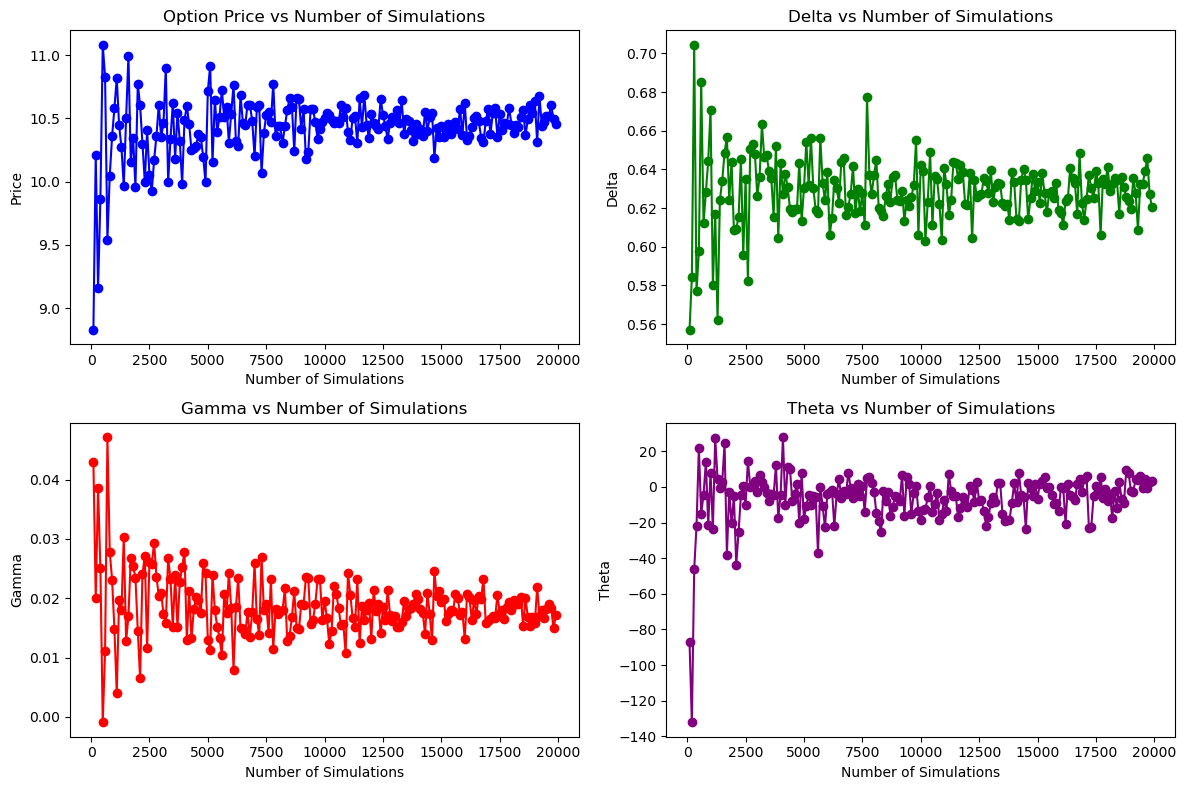

In [598]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(100, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

# Excercise 2.5.2 Monte-Carlo Using the Euler schema with ln(St) condition

In [599]:
def euler_simulate_stock_paths(S0, sigma, T, r, N, dt):
    steps = int(T / dt)
    dt_sqrt = np.sqrt(dt)
    paths = np.zeros((N, steps + 1))
    paths[:, 0] = np.log(S0)
    for i in range(1, steps + 1):
        Z = np.random.standard_normal(N)
        paths[:, i] = paths[:, i - 1] + (r - 0.5 * sigma ** 2) * dt + sigma * dt_sqrt * Z
    return paths[:, -1]

In [600]:
def ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt):
    ln_ST = euler_simulate_stock_paths(S0, sigma, T, r, N, dt)
    ST = np.exp(ln_ST)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ln_ST_plus = euler_simulate_stock_paths(S0 + dS, sigma, T, r, N, dt)
    ln_ST_minus = euler_simulate_stock_paths(S0 - dS, sigma, T, r, N, dt)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_plus) - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_minus) - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 0.1
    # Theta calculation
    ln_ST_future = euler_simulate_stock_paths(S0, sigma, T + dT, r, N, dt)
    ln_ST_past = euler_simulate_stock_paths(S0, sigma, T - dT, r, N, dt)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(np.exp(ln_ST_future) - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(np.exp(ln_ST_past) - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)

    return C0, delta, gamma, theta

In [347]:
N = 10000
dt = 1/ 365
option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.55811
Delta: 0.64146
Gamma: 0.01725
Theta: -6.95521


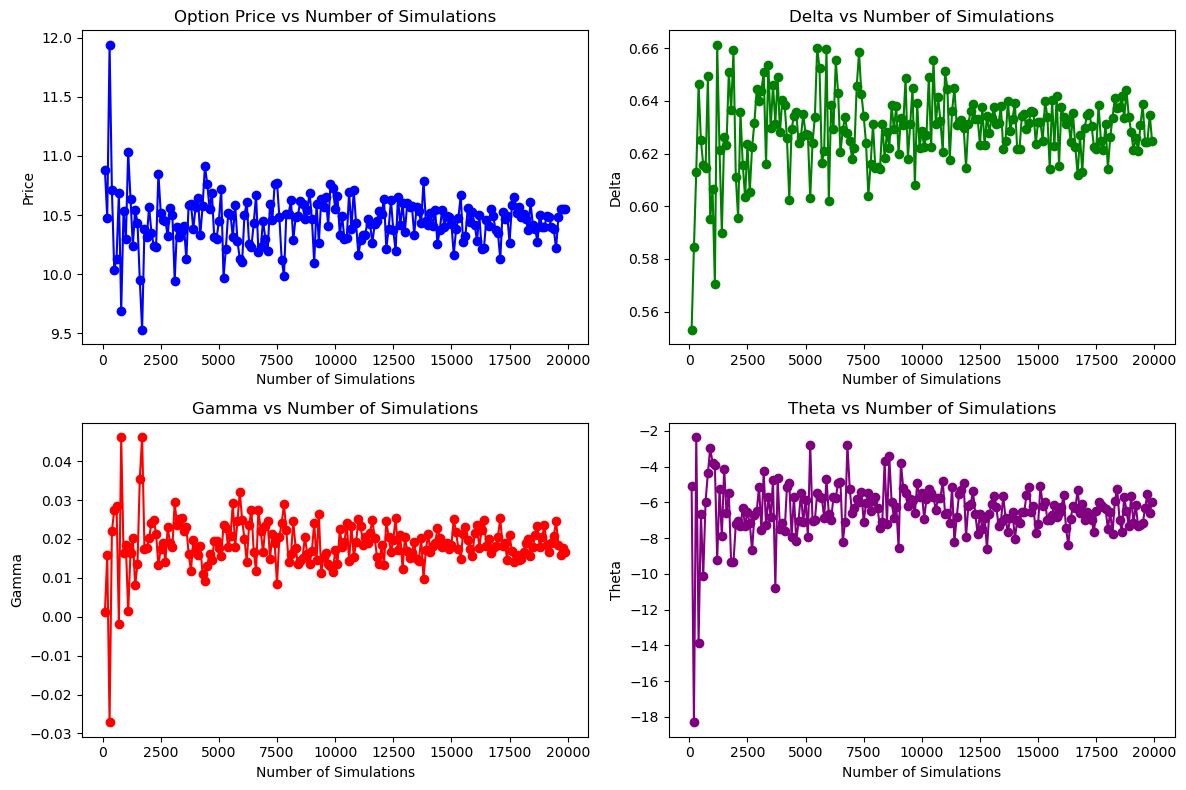

In [601]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(100, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n, dt)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

# Excercise 2.5.3 Monte-Carlo Using the Milstein schema with ln(St) condition

In [602]:
def Milstein_simulate_stock_paths(S0, sigma, T, r, N, dt):
    steps = int(T / dt)
    dt_sqrt = np.sqrt(dt)
    paths = np.zeros((N, steps + 1))
    paths[:, 0] = np.log(S0)
    for i in range(1, steps + 1):
        Z = np.random.standard_normal(N)
        paths[:, i] = paths[:, i - 1] + (r - 0.5 * sigma ** 2) * dt + sigma * dt_sqrt * Z
    return paths[:, -1] 

In [603]:
def ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt):
    ln_ST = Milstein_simulate_stock_paths(S0, sigma, T, r, N, dt)
    ST = np.exp(ln_ST)
    payoff = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ln_ST_plus = Milstein_simulate_stock_paths(S0 + dS, sigma, T, r, N, dt)
    ln_ST_minus = Milstein_simulate_stock_paths(S0 - dS, sigma, T, r, N, dt)
    C0_plus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_plus) - K, 0))
    C0_minus = np.exp(-r * T) * np.mean(np.maximum(np.exp(ln_ST_minus) - K, 0))
    delta = (C0_plus - C0_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (C0_plus - 2 * C0 + C0_minus) / (dS ** 2)

    dT = 0.1
    # Theta calculation
    ln_ST_future = Milstein_simulate_stock_paths(S0, sigma, T + dT, r, N, dt)
    ln_ST_past = Milstein_simulate_stock_paths(S0, sigma, T - dT, r, N, dt)
    C0_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(np.exp(ln_ST_future) - K, 0))
    C0_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(np.exp(ln_ST_past) - K, 0))
    theta = -(C0_future - C0_past) / (2 * dT)

    return C0, delta, gamma, theta

In [353]:
N = 10000
dt = 1/ 365
option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, N, dt)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 10.46296
Delta: 0.63630
Gamma: 0.02115
Theta: -5.58882


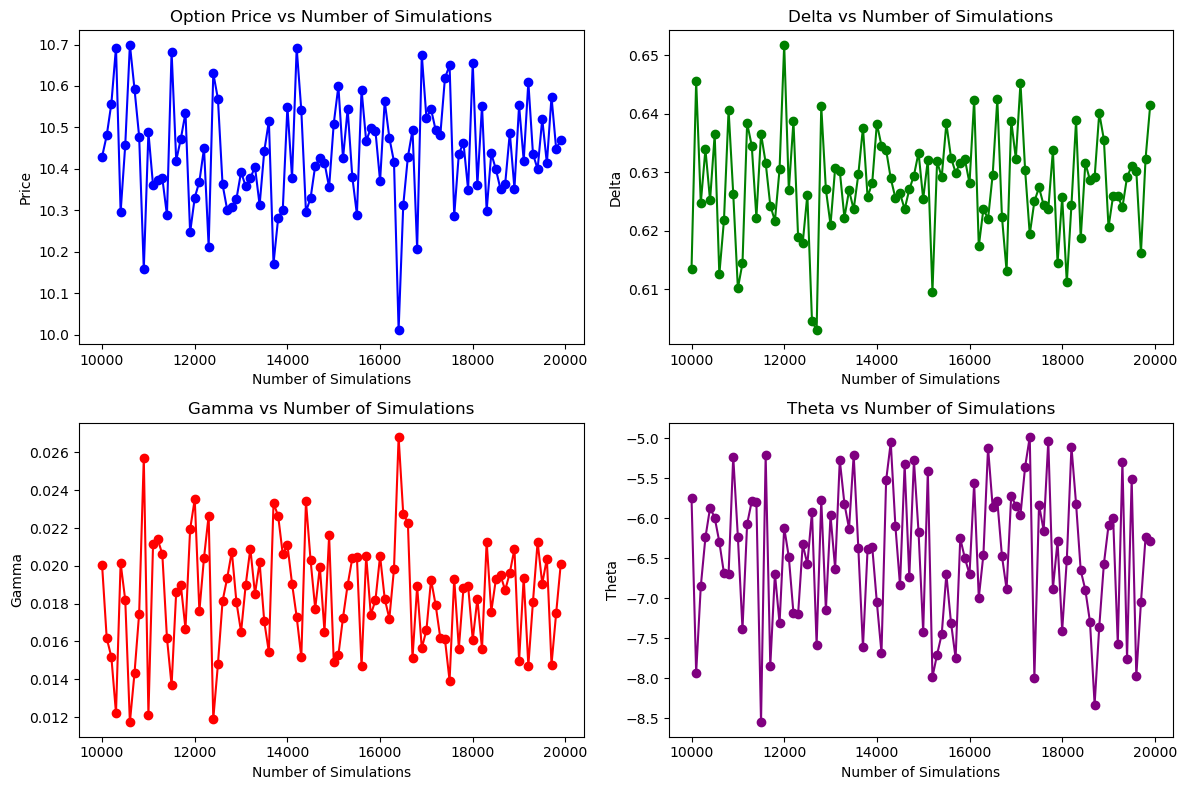

In [604]:
# plot the option price with different number of simulations
option_prices = []
deltas = []
gammas = []
thetas = []
N = np.arange(10000, 20000, 100)
for n in N:
    option_price, delta, gamma, theta = ln_monte_carlo_call_price_and_greeks(S0, sigma, T, K, r, n, dt)
    option_prices.append(option_price)
    deltas.append(delta)
    gammas.append(gamma)
    thetas.append(theta)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(N, option_prices, marker='o', color='blue')
plt.title('Option Price vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.plot(N, deltas, marker='o', color='green')
plt.title('Delta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Delta')

plt.subplot(2, 2, 3)
plt.plot(N, gammas, marker='o', color='red')
plt.title('Gamma vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Gamma')

plt.subplot(2, 2, 4)
plt.plot(N, thetas, marker='o', color='purple')
plt.title('Theta vs Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

# Exercise 3 Back to the forward

# Exercise 3.1

In [605]:
def implicit_option_pricing(S0, K, T, r, sigma, M, N):
    dt = T / N
    dS = 2 * S0 / M
    Smax = 2 * S0

    S = np.linspace(0, Smax, M + 1)
    t = np.linspace(0, T, N + 1)

    V = S - K
    V_prev = np.zeros(M + 1)  

    a = -0.5 * dt * (sigma ** 2 * np.arange(M + 1) ** 2 - r * np.arange(M + 1))
    b = 1 + dt * (sigma ** 2 * np.arange(M + 1) ** 2 + r)
    c = -0.5 * dt * (sigma ** 2 * np.arange(M + 1) ** 2 + r * np.arange(M + 1))

    for j in range(N - 1, -1, -1):
        A = np.diag(b) + np.diag(a[1:], -1) + np.diag(c[:-1], 1)

        V[0] = 0
        V[-1] = Smax - K * np.exp(-r * (T - t[j]))

        V_prev = V.copy() 
        V = np.linalg.solve(A, V)

    i = M // 2
    option_price = V[i]
    delta = (V[i + 1] - V[i - 1]) / (2 * dS)
    gamma = (V[i + 1] - 2 * V[i] + V[i - 1]) / (dS ** 2)
    theta = -(V[i] - V_prev[i]) / dt  
    return option_price, delta, gamma, theta

option_price, delta, gamma, theta = implicit_option_pricing(100, 100, 1, 0.05, 0.2, 100, 3000)

print(f"Option Price: {option_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 4.87144
Delta: 0.99900
Gamma: -0.00015
Theta: -4.72093


# Exercise 3.2

In [606]:
def simulate_stock_paths(S0, sigma, T, r, N):
    Z = np.random.standard_normal(N)
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    return ST

In [607]:
def monte_carlo_forward_price_and_greeks(S0, sigma, T, K, r, N):
    ST = simulate_stock_paths(S0, sigma, T, r, N)
    payoff = ST - K
    forward_price = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    ST_plus = simulate_stock_paths(S0 + dS, sigma, T, r, N)
    ST_minus = simulate_stock_paths(S0 - dS, sigma, T, r, N)
    forward_price_plus = np.exp(-r * T) * np.mean(ST_plus - K)
    forward_price_minus = np.exp(-r * T) * np.mean(ST_minus - K)
    delta = (forward_price_plus - forward_price_minus) / (2 * dS)
    
    # Gamma calculation
    gamma = (forward_price_plus - 2 * forward_price + forward_price_minus) / (dS ** 2)

    dT = 0.1
    # Theta calculation
    ST_future = simulate_stock_paths(S0, sigma, r, T + dT, N)
    ST_past = simulate_stock_paths(S0, sigma, r, T - dT, N)
    forward_price_future = np.exp(-r * (T + dT)) * np.mean(ST_future - K)
    forward_price_past = np.exp(-r * (T - dT)) * np.mean(ST_past - K, 0)
    theta = -(forward_price_future - forward_price_past) / (2 * dT)

    return forward_price, delta, gamma, theta

In [611]:
N = 200000
forward_price, delta, gamma, theta = monte_carlo_forward_price_and_greeks(S0, sigma, T, K, r, N)

print(f"Option Price: {forward_price:.5f}")
print(f"Delta: {delta:.5f}")
print(f"Gamma: {gamma:.5f}")
print(f"Theta: {theta:.5f}")

Option Price: 4.87480
Delta: 1.00108
Gamma: -0.00061
Theta: -4.80291


# Excerise 4.1

In [612]:
def monte_carlo_spread_option(S0, X0, sigma1, sigma2, rho, T, r, Kspread, N):
    np.random.seed(2)
    Z1 = np.random.standard_normal(N)
    Z2 = np.random.standard_normal(N)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

    S1_T = S0 * np.exp((r - 0.5 * sigma1**2) * T + sigma1 * np.sqrt(T) * Z1)
    S2_T = X0 * np.exp((r - 0.5 * sigma2**2) * T + sigma2 * np.sqrt(T) * Z2)

    payoff = np.maximum(S1_T - S2_T - Kspread, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)
    
    dS = 0.1 * S0
    # Delta calculation
    S1_T_plus = (S0 + dS) * np.exp((r - 0.5 * sigma1**2) * T + sigma1 * np.sqrt(T) * Z1)
    S1_T_minus = (S0 - dS) * np.exp((r - 0.5 * sigma1**2) * T + sigma1 * np.sqrt(T) * Z1)
    payoffs_up = np.maximum(S1_T_plus - S2_T - Kspread, 0)
    payoffs_down = np.maximum(S1_T_minus - S2_T - Kspread, 0)
    option_price_plus = np.exp(-r * T) * np.mean(payoffs_up)
    option_price_minus = np.exp(-r * T) * np.mean(payoffs_down)
    delta_s = (option_price_plus - option_price_minus) / (2 * dS)
    
    # Gamma calculation
    gamma_s = (option_price_plus - 2 * option_price + option_price_minus) / (dS ** 2)

    dT = 1/ 365
    # Theta calculation
    S1_T_future = S0 * np.exp((r - 0.5 * sigma1**2) * (T + dT) + sigma1 * np.sqrt(T + dT) * Z1)
    S1_T_past = S0 * np.exp((r - 0.5 * sigma1**2) * (T - dT) + sigma1 * np.sqrt(T - dT) * Z1)
    option_price_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(S1_T_future - S2_T - Kspread, 0))
    option_price_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(S1_T_past - S2_T - Kspread, 0))
    theta_s = -(option_price_future - option_price_past) / (2 * dT)
    
    dX = 0.1 * X0
    # Delta calculation
    S2_T_plus = (X0 + dX) * np.exp((r - 0.5 * sigma2**2) * T + sigma2 * np.sqrt(T) * Z2)
    S2_T_minus = (X0 - dX) * np.exp((r - 0.5 * sigma2**2) * T + sigma2 * np.sqrt(T) * Z2)
    payoffs_up = np.maximum(S1_T - S2_T_plus - Kspread, 0)
    payoffs_down = np.maximum(S1_T - S2_T_minus - Kspread, 0)
    option_price_plus = np.exp(-r * T) * np.mean(payoffs_up)
    option_price_minus = np.exp(-r * T) * np.mean(payoffs_down)
    delta_x = (option_price_plus - option_price_minus) / (2 * dX)
    
    # Gamma calculation
    gamma_x = (option_price_plus - 2 * option_price + option_price_minus) / (dX ** 2)

    # Theta calculation
    S2_T_future = X0 * np.exp((r - 0.5 * sigma2**2) * (T + dT) + sigma2 * np.sqrt(T + dT) * Z2)
    S2_T_past = X0 * np.exp((r - 0.5 * sigma2**2) * (T - dT) + sigma2 * np.sqrt(T - dT) * Z2)
    option_price_future = np.exp(-r * (T + dT)) * np.mean(np.maximum(S1_T - S2_T_plus - Kspread, 0))
    option_price_past = np.exp(-r * (T - dT)) * np.mean(np.maximum(S1_T - S2_T_minus - Kspread, 0))
    theta_x = -(option_price_future - option_price_past) / (2 * dX)

    return option_price, delta_s, gamma_s, theta_s, delta_x, gamma_x, theta_x

In [441]:
option_price, delta_s, gamma_s, theta_s, delta_x, gamma_x, theta_x = monte_carlo_spread_option(100, 90, 0.2, 0.3, 0.5, 1, 0.05, 8, 10000)
print("Option Price:", option_price)
print(f"Delta for stock S: {delta_s:.5f}")
print(f"Gamma for stock S: {gamma_s:.5f}")
print(f"Theta for stock S: {theta_s:.5f}")
print(f"Delta for stock X: {delta_x:.5f}")
print(f"Gamma for stock X: {gamma_x:.5f}")
print(f"Theta for stock X: {theta_x:.5f}")

Option Price: 10.722822740183934
Delta for stock S: 0.57341
Gamma for stock S: 0.01595
Theta for stock S: -3.23094
Delta for stock X: -0.47864
Gamma for stock X: 0.01680
Theta for stock X: 0.47881


# Excerise 4.2

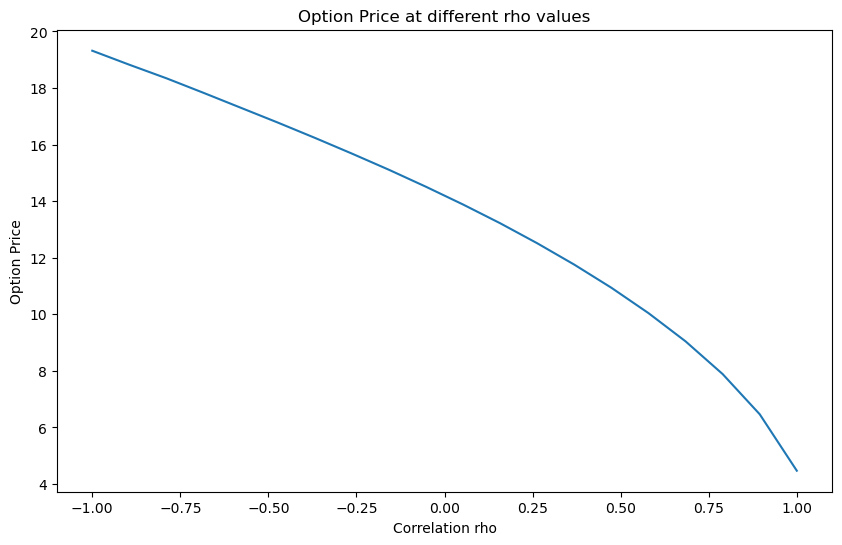

In [613]:
# plot the option price at inception for different N values
option_prices = []
rho = np.linspace(-1, 1, 20)
for r in rho:
    option_price, delta_s, gamma_s, theta_s, delta_x, gamma_x, theta_x = monte_carlo_spread_option(100, 90, 0.2, 0.3, r, 1, 0.05, 8, 10000)
    option_prices.append(option_price)
    

plt.figure(figsize=(10, 6))
plt.plot(rho, option_prices)
plt.title('Option Price at different rho values')
plt.xlabel('Correlation rho')
plt.ylabel('Option Price')
plt.show()

# Exercise 5 Dynamic Hedging In Action

# Exercise 5.1 Expected final PnL

In [514]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    delta = norm.cdf(d1)
    
    return call_price, delta

call_price, delta = black_scholes_call(100, 100, 1, 0.05, 0.2)

def simulate_stock_paths(S0, sigma, T, mu, dt, N):
    num_steps = int(T / dt) 
    dt = T / num_steps 
    paths = np.zeros((num_steps + 1, N))
    paths[0] = S0
    for t in range(1, num_steps + 1):
        Z = np.random.standard_normal(N) 
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths[-1]

Stock_price = simulate_stock_paths(100, 0.2, 1, 0.07, 0.01,1000)
call_payoff = np.mean(np.maximum(Stock_price - K, 0))

cost_of_shares = delta * S0
value_of_shares = delta * S_final
final_pnl = call_price - call_payoff + (value_of_shares - cost_of_shares)

print("Final PNL:", final_pnl)
print("Call Price:", call_price)

Final PNL: 3.3051033289029252
Call Price: 10.450583572185565


# Exercise 5.2 perform monthly hedge

In [523]:
def simulate_stock_paths(S0, sigma, T, mu, dt, N):
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, N))
    paths[0, :] = S0
    for t in range(1, num_steps + 1):
        Z = np.random.standard_normal(N)
        paths[t, :] = paths[t - 1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def pnl_hedge(S0, K, T, mu, sigma, dt, N, r):
    stock_paths = simulate_stock_paths(S0, sigma, T, mu, dt, N)
    final_pnls = []

    initial_call_price, initial_delta = black_scholes_call(S0, K, T, r, sigma)

    for path in stock_paths.T:
        cash = initial_call_price 
        for t in range(int(T / dt)):
            current_price = path[t]
            remaining_T = T - t * dt
            call_price, delta = black_scholes_call(current_price, K, remaining_T, r, sigma)
            # Adjust hedge
            if t == 0:
                shares_held = delta
                cash -= shares_held * current_price  # Buying initial shares to hedge
            else:
                shares_to_buy = delta - shares_held
                cash -= shares_to_buy * current_price
                shares_held = delta

        # Final adjustment at maturity
        final_stock_price = path[-1]
        call_payoff = max(final_stock_price - K, 0)
        cash += shares_held * final_stock_price - call_payoff
        final_pnls.append(cash)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.hist(final_pnls, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel('Final PnL')
    plt.ylabel('Frequency')
    plt.show()


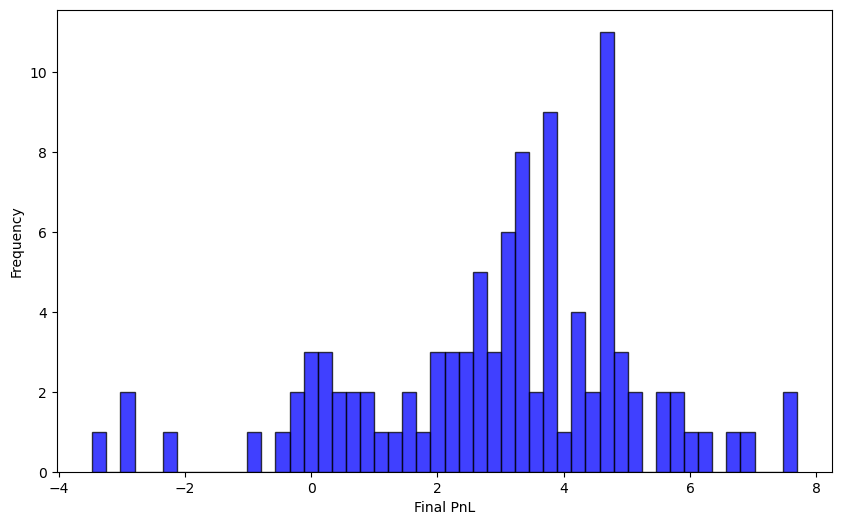

In [524]:
dt = 1/12
pnl_hedge(100, 100, 1, 0.07, 0.2, dt, 100, 0.05)

# Exercise 5.3 perform weekly hedge

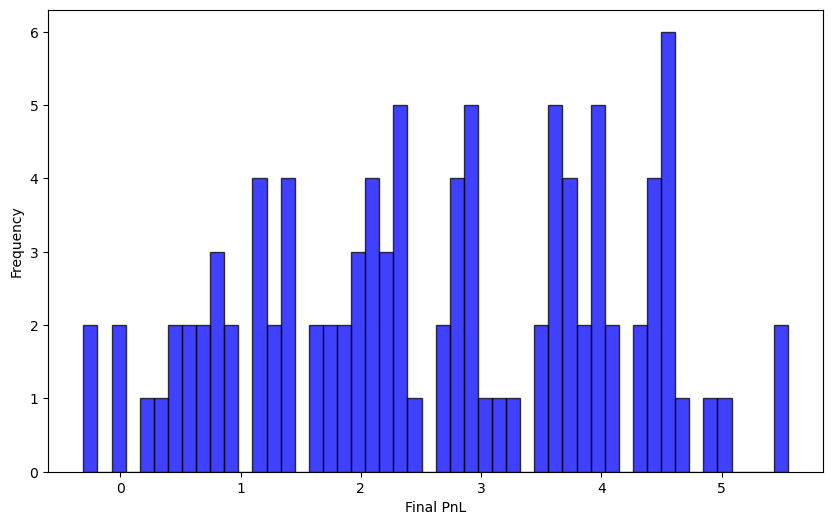

In [526]:
dt = 1/52
pnl_hedge(100, 100, 1, 0.07, 0.2, dt, 100, 0.05)

# Exercise 5.4 perform daily hedge

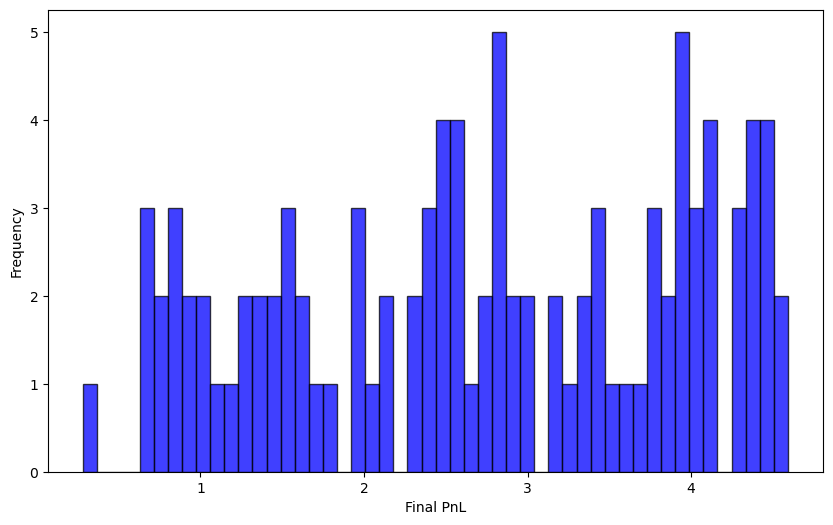

In [528]:
dt = 1/365
pnl_hedge(100, 100, 1, 0.07, 0.2, dt, 100, 0.05)